# Movie Budgets EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from helper import *

As a first step, we want to account for the inflation in order to convert all amounts in 2016 dollars and be able to determine the type of budget of a movie. To do so we use a csv created from the data on [this site](http://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/): the file contains the year, the average consumer price index (CPI) of that year and the cumulative inflation percentage that we'll use to adjust the amounts.

In [2]:
budgets = pd.read_pickle('pickle/budgets_scraped.p')

In [3]:
inflation = pd.read_csv('data/us_dollar_inflation.csv', sep=';')
inflation.head()

,year,avg_cpi,avg_cumulative_inflation,avg_cumulative_inflation_perc
0,1913,9.9,24.243131,23.24
1,1914,10.0,24.000700,23.00
2,1915,10.1,23.763069,22.76
3,1916,10.9,22.018991,21.02
4,1917,12.8,18.750547,17.75


We add the year column to the budgets and we join the two dataframes:

In [4]:
budgets['release_year'] = budgets.release_date.dt.year

In [5]:
budgets = budgets.merge(inflation[['year', 'avg_cumulative_inflation']],
                        left_on='release_year',
                        right_on='year',
                        how='left').drop('year', axis=1)

Finally, we calculate domestic and worldwide ROI and the amounts in 2016 dollars and take a look at the top 10 movies by worldwide ROI:

In [6]:
budgets['domestic_ROI'] = (budgets.domestic_gross - budgets.production_budget) / budgets.production_budget
budgets['worldwide_ROI'] = (budgets.worldwide_gross - budgets.production_budget) / budgets.production_budget
budgets['adj_production_budget'] = budgets.production_budget * budgets.avg_cumulative_inflation
budgets['adj_domestic_gross'] = budgets.domestic_gross * budgets.avg_cumulative_inflation
budgets['adj_worldwide_gross'] = budgets.worldwide_gross * budgets.avg_cumulative_inflation

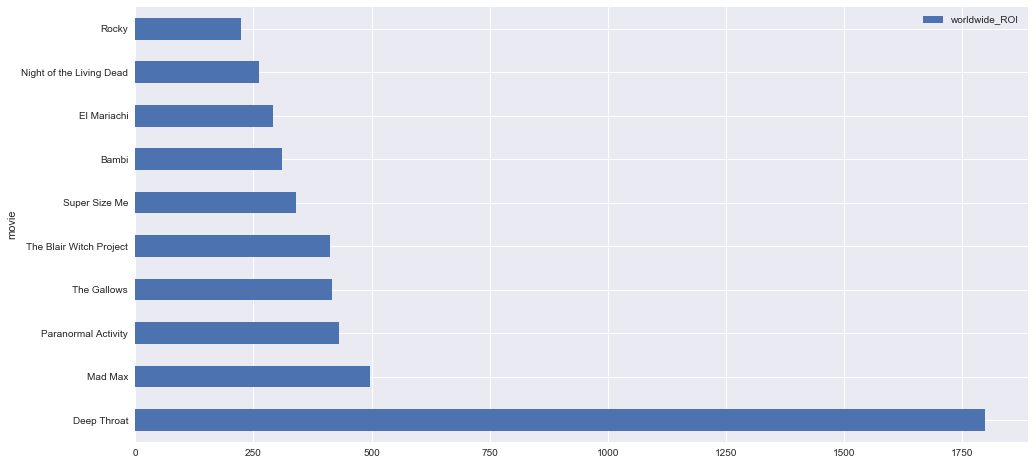

In [7]:
ax = budgets.sort_values(by='worldwide_ROI', ascending=False).head(10).plot.barh(x='movie', y='worldwide_ROI', figsize=(16, 8))
fig = ax.get_figure()
fig.savefig('figures/top_movies_worldwide.png');

Now let's add the budget type column. We can refer to [this article](https://stephenfollows.com/average-budget-low-micro-budget-film/) to get some values to differentiate micro, low and normal budget movies:

In [8]:
budgets['budget_type'] = budgets.adj_production_budget.apply(budget_type)

These are the top 10 normal budget movies by worldwide ROI:

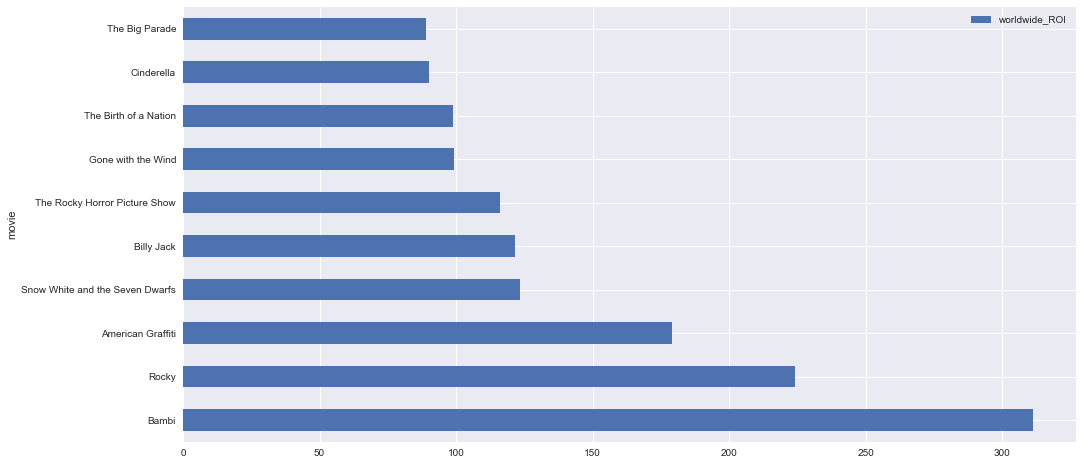

In [9]:
ax = budgets[budgets.budget_type=='normal'].sort_values(by='worldwide_ROI', ascending=False).head(10).plot.barh(x='movie', y='worldwide_ROI', figsize=(16, 8));
fig = ax.get_figure()
fig.savefig('figures/top_normal_movies_worldwide.png');

Let's also look at how the new quantities we introduced vary throughout the years:

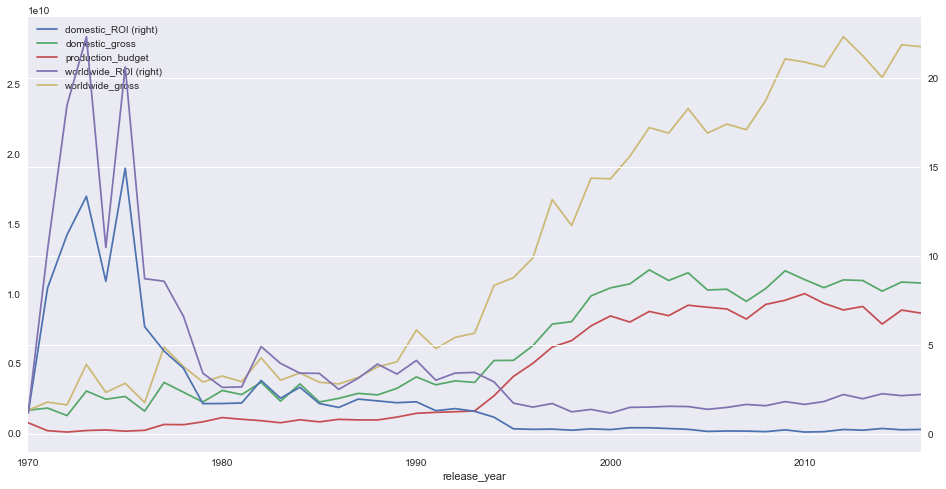

In [10]:
budgets[(budgets.release_year <= 2016) & (budgets.release_year >= 1970)].groupby('release_year').apply(
lambda x: pd.Series({
    'domestic_gross': x.adj_domestic_gross.sum(),
    'worldwide_gross': x.adj_worldwide_gross.sum(),
    'production_budget': x.adj_production_budget.sum(),
    'domestic_ROI': (x.domestic_gross.sum() - x.production_budget.sum()) / x.production_budget.sum(),
    'worldwide_ROI': (x.worldwide_gross.sum() - x.production_budget.sum()) / x.production_budget.sum()
})
).plot(secondary_y=['domestic_ROI', 'worldwide_ROI'], figsize=(16, 8));

We can see a some peaks for the ROI in the 1970s (which could be investigated more thoroughly), a visible increase for budget and gross after the mid 1990s and, for the worldwide gross, a general divergent trend with respect to the domestic gross.

We can also inspect the data to see if it exist some kind of seasonality.

First, we add a date column to help us analyze all movies with respect to their day and month of release and create a new dataframe with the daily data:

In [11]:
budgets['release_month_day'] = budgets.apply(lambda x: pd.to_datetime('2016-' + str(x.release_date.month) + '-' + str(x.release_date.day)), axis=1)

In [12]:
daily_budgets = budgets[(budgets.release_year <= 2016) & (budgets.release_year >= 2000)].groupby('release_month_day').apply(
lambda x: pd.Series({
    'domestic_gross': x.adj_domestic_gross.sum(),
    'worldwide_gross': x.adj_worldwide_gross.sum(),
    'production_budget': x.adj_production_budget.sum(),
    'domestic_ROI': (x.domestic_gross.sum() - x.production_budget.sum()) / x.production_budget.sum(),
    'worldwide_ROI': (x.worldwide_gross.sum() - x.production_budget.sum()) / x.production_budget.sum()
}))

Now we plot the worldwide ROI by day of the year:

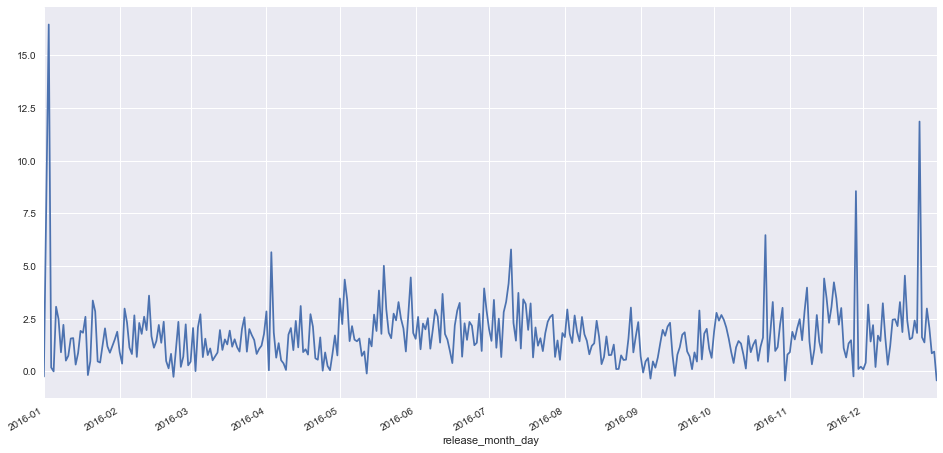

In [13]:
daily_budgets.worldwide_ROI.plot(figsize=(16, 8));

We can see some peaks at the end and beginning of the year and in some other periods; we could try to smooth out the graph by taking a rolling mean of seven days:

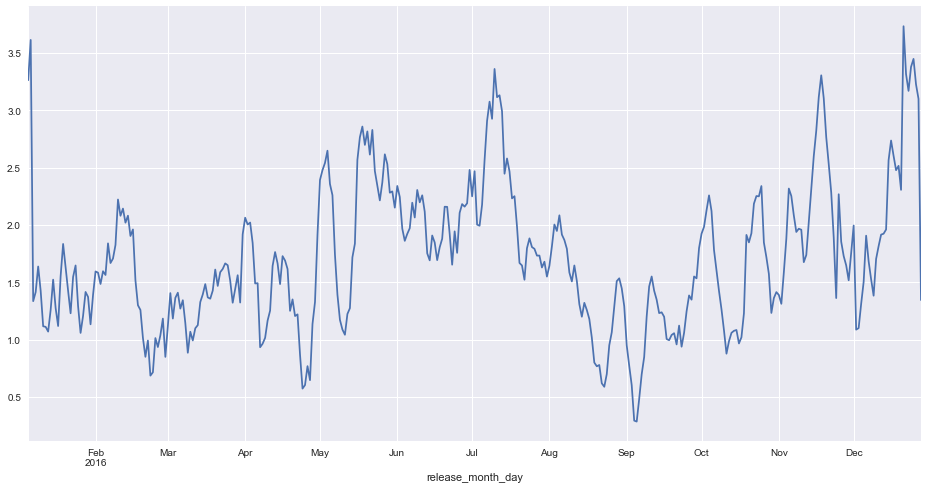

In [14]:
ax = daily_budgets.rolling(7, center=True).mean().dropna().worldwide_ROI.plot(figsize=(16, 8));
fig = ax.get_figure()
fig.savefig('figures/ROI_seasonality.png');

From this plot we see some clear peaks: one in the winter holidays, one at the beginning of July and one in mid-November. We also see some periods of the year where the ROI is clearly lower.

There seems to be some seasonality in the data but we have many ups and downs which make it difficult to spot it.

Finally, we plot worldwide ROI mean by month:

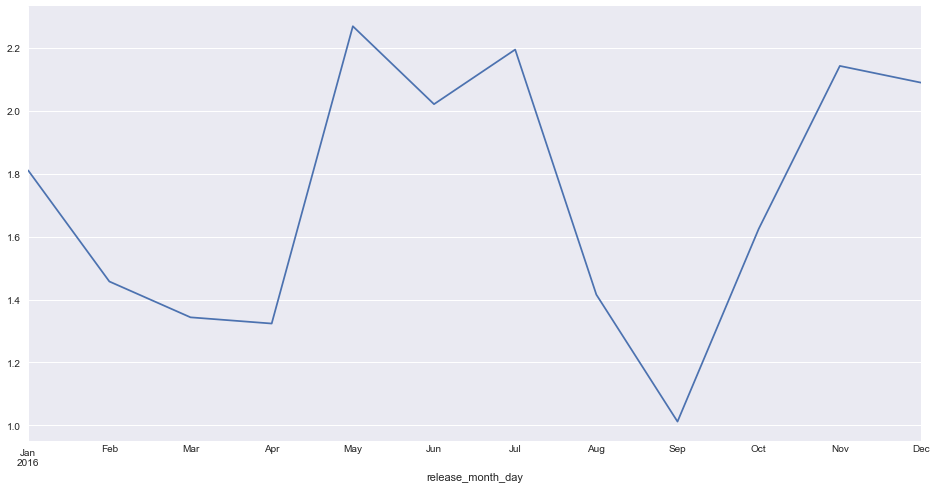

In [15]:
daily_budgets.resample('M').mean().dropna().worldwide_ROI.plot(figsize=(16, 8));

The best months to release a movie seem to be from May to July, November and December. We could test to see if this difference is meaningful.

Finally we save the data in a pickle for future reuse.

In [16]:
budgets.to_pickle('pickle/budget_cleaned.p')